In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
df_DE = df[df['job_country'] == 'Germany']

In [3]:
df_skills = df_DE.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",python
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",sql
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",c#
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",azure
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",airflow
...,...,...
785735,Senior Data Engineer,docker
785737,CRM Data Analyst,sas
785737,CRM Data Analyst,sas
785737,CRM Data Analyst,sql


In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()
df_skills_count

job_skills  job_title_short          
airflow     Business Analyst              12
            Cloud Engineer                 3
            Data Analyst                  87
            Data Engineer                823
            Data Scientist               156
                                        ... 
zoom        Machine Learning Engineer      1
            Senior Data Analyst            5
            Senior Data Engineer           3
            Senior Data Scientist          1
            Software Engineer              2
Length: 1382, dtype: int64

In [5]:
# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count


,job_skills,job_title_short,skill_count
907,python,Data Scientist,4157
906,python,Data Engineer,3524
1139,sql,Data Engineer,3145
1138,sql,Data Analyst,2947
905,python,Data Analyst,2309
...,...,...,...
254,django,Business Analyst,1
255,django,Cloud Engineer,1
256,django,Data Analyst,1
1127,spring,Senior Data Scientist,1


In [6]:
#Create List of Top 3 Roles. Focus: Data Analysts, Data Engineers, and Data Scientists. Filter the job titles based on the most popular.
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

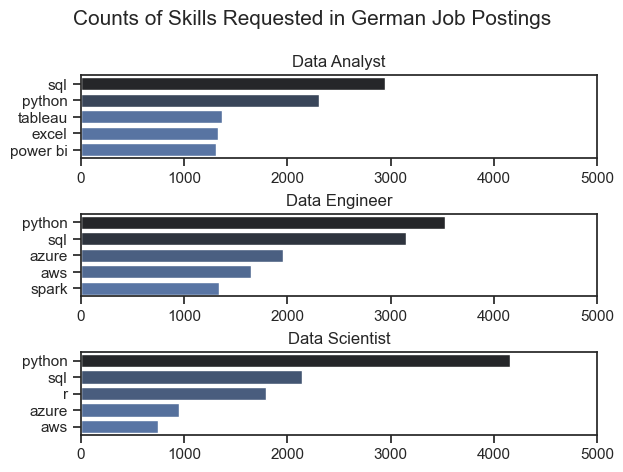

In [8]:
#Plot Skills - a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 5000) # make the scales the same

fig.suptitle('Counts of Skills Requested in German Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

In [9]:
#Convert Counts to Percentages. Focus: Counts don't show what portions of jobs are requesting these skills
# Use original df to get the count of job titles
df_job_title_count = df_DE['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,7131
1,Data Scientist,6745
2,Data Engineer,6675
3,Senior Data Engineer,2041
4,Senior Data Scientist,1737
5,Senior Data Analyst,1216
6,Business Analyst,817
7,Software Engineer,741
8,Machine Learning Engineer,402
9,Cloud Engineer,189


In [10]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Scientist,4157,6745,61.630838
1,python,Data Engineer,3524,6675,52.794007
2,sql,Data Engineer,3145,6675,47.116105
3,sql,Data Analyst,2947,7131,41.326602
4,python,Data Analyst,2309,7131,32.379750
...,...,...,...,...,...
1377,django,Business Analyst,1,817,0.122399
1378,django,Cloud Engineer,1,189,0.529101
1379,django,Data Analyst,1,7131,0.014023
1380,spring,Senior Data Scientist,1,1737,0.057571


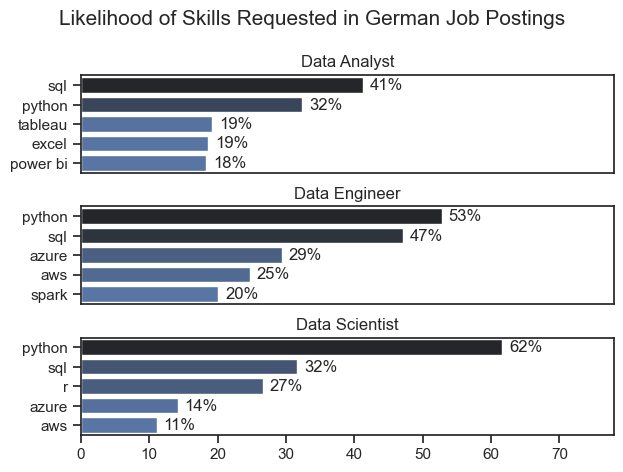

In [11]:
#Plot Percentage Count - Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in German Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()